In [228]:
#Задача оптимального управления
# пример 2.4
# пример 2.5
# привет Li-Hames

In [1]:
import math as m
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import time
from copy import deepcopy
from numpy.linalg import matrix_power
from scipy.linalg import block_diag

In [77]:
class Kite:
    def __init__(
        self, 
        u: List[float], #kite location
        v: List[float], #kite velocity
        f: float #f value
             ):
        self.u = u
        self.v = v
        self.f = f
        
class KiteSwarm:
    def __init__(
        self,
        swarm_size: int, #swarm size
        dim: int, #dimentions
        iter_max: int, #max number of iterations
        Nc: int, #control horizont
        Np: int, #horisont of prediction
        integr_steps: int, #number of integration steps --- (Nmax in article)
        step_size: float, #size of integration steps --- (h in article)
        closenes: float, #parameter of closenes --- (q in article)
        deleted_kites: float, #parameter of deleted kites --- (sigma in article)
        dist_min: float, #minimal distance from food to kite's leader
        k: float, #coeffitient of proportional navigation  
        area_u, #area for the control generation
        task_type_max, #min (sort False) or max (sort True)
    ):
        #_________PARAMETERS of ALG______
        self.swarm_size = swarm_size
        self.dim = dim
        self.u_dim = dim-1
        self.iter_max = iter_max
        self.Nc = Nc # Np have to be greater than Nc ! (do I need to check it?)
        self.Np = Np
        self.integr_steps = integr_steps
        self.step_size = step_size
        self.closenes = closenes
        self.deleted_kites = deleted_kites
        self.dist_min = dist_min
        self.k = k
        self.area_u = np.array(area_u)
        self.task_type_max = task_type_max
        
        self.population = [] #list of kites
        self.pool = []
        
        self.vector_r = [] # leader's location and velocity (const for current iter and  swarm)
        self.vector_x_ki = [] # vector for current kite at the moment t
        self.vector_x = [] #
        
        
        self.MOMENT = 0
        #_________KITES FOR STEP 3______
        best_kite = []
        leader_kite = []
        first_kite = []
        second_kite = []
        third_kite = []
        
        #_________PARAMETERS FOR CONTROL______
        self.best_x1 = []
        self.best_x2 = []
        
        
        #_________MATRIX______
        self.E = np.eye(self.u_dim)
        
        self.hE =  self.step_size * self.E
        self.h2E = self.step_size**2 / 2 * self.E
        self.zero_mtrx = np.zeros((self.u_dim, self.u_dim))
        
        # init matrix A
        self.A = np.block([
            [self.E, self.hE], \
            [self.zero_mtrx, self.E]
        ])
        
        # init matrix B
        self. B = np.block([
            [self.h2E], \
            [self.hE]
        ])
        
        # init matrix B
        self.Q = self.closenes * np.eye(self.u_dim * self.Nc)
        
        tmp_A = np.block([
            [self.E, self.hE], \
            [self.zero_mtrx, self.E]
        ])
        
        # init matrix F
        A_list = [list(matrix_power(self.A,i+1)) for i in range(self.Np)]
        self.F = block_diag(*A_list)
        
        
        # init matrix Phi

        self.zero_B = np.zeros((2*self.u_dim, self.u_dim))
        
        list_columns = []
        
        # run through the columns
        for i in range(self.Np):
            # run through the rows in current column
            list_row = []
            for j in range(self.Nc):
                    
                if(j <= i):                        
                    list_row.append(matrix_power(self.A, (i-j)).dot(self.B))
                
                else:
                    list_row.append(self.zero_B)
            list_columns.append(list_row)
        self.Phi = np.block(list_columns)
        
    #_________________CALC FUNCTIONS_________________     
    def init_area(self, control):
        self.area = [self.area_u for i in range(self.u_dim)] # было N_step - 1 вместо u.dim
        self.area_new = deepcopy(self.area)
        self.exact = control.ExactI()

    
    # creration a first population of kites 
    def form_first_pop(self, control):
        self.population.clear()
        for i in range(self.swarm_size):
            coordinate = np.array([np.random.rand() * (self.area[j][1] - self.area[j][0]) + self.area[j][0] for j in range(self.u_dim)])

            velocity = np.array([(np.random.rand() * (self.area[j][1] - self.area[j][0]) + self.area[j][0]) / self.integr_steps for j in range(self.u_dim)])
            
            member = Kite(coordinate, velocity, 0)
            self.population.append(member)
            
        
    
    def func_calculate(self, control):
        for i in range(self.swarm_size): 
            coordinate = self.population[i].u
            result = control.Functional(coordinate)
            self.population[i].f = result
            
    def func_barr1(self, step4, control):
        # определим списки
        self.vector_x.clear()
        vector_u = []
        kite_path_barr = [] # стая на каждом шаге
        kite_population_next_step = []
        best_in_each_track = []

        # перелет каждой особи
        for k_i in range(0, self.swarm_size):
            # очистим все списки
            vector_u = list(vector_u)
            vector_u.clear()

    #         kite.vector_x - список всех векторов состояний на горизонте 

            # временно определим vector_r, x_k_i 
            self.vector_x_ki = np.array([np.concatenate([self.population[k_i].u, self.population[k_i].v]) for i in range(self.Np)])

            # deepcopy R, X_ki для мат операций
            tmp_r = deepcopy(self.vector_r)
            tmp_x_ki = deepcopy(self.vector_x_ki)


            # reshape R, X_ki для мат операций
            tmp_r = np.array(tmp_r).reshape((2 * self.u_dim * self.Np, 1))
            tmp_x_ki = np.array(tmp_x_ki).reshape((2 * self.u_dim * self.Np, 1))


            # --------------ОПРЕДЕЛЕНИЕ ВЕКТОРА U + reshape--------------
            u = np.linalg.inv(self.Phi.transpose().dot(self.Phi) + self.Q).dot(self.Phi.transpose()).dot(tmp_r - self.F.dot(tmp_x_ki))
            vector_u.append(u) #зачем аппенд если можно сразу преобразовать в вектор? 

            vector_u = np.block(vector_u) #чтобы из списка преобразовать в матрицу?
            vector_u = vector_u.reshape((self.u_dim, self.Nc)).transpose()
    #         print('u', '\n', vector_u)


            # --------------ОПРЕДЕЛЕНИЕ ВЕКТОРА U  для шага 2.1 или 4--------------
            if(step4 == 0):
                temp = np.zeros((self.Nc, self.Nc))
                temp[0, 0] = 1.0
                u = temp.dot(vector_u)
    #             print('u', '\n', u)


            kite_path_barr.clear()

            # --------------ВЫЧИСЛЕНИЕ НОВЫХ КООРДИНАТ (ТЕКУЩЕГО КОРШУНА) ВЕКТОРА X_ki--------------
            # когда Nc (Nc<Np) заканчивается, u определяем как [0., 0.]
            for i in range(self.Np):

                if(i < len(vector_u)):
                    u_i = vector_u[i]
                else:
                    u_i = np.zeros(self.u_dim)

                tmp_x = self.A.dot(self.vector_x_ki[i]) + self.B.dot(u_i) 
                coordinate = tmp_x[:self.u_dim]
                velocity = tmp_x[self.u_dim: self.u_dim*2+1]


                # проверка на выход за границы, если вышли - берем крайнее значение
                for j in range(len(coordinate)):
                    if coordinate[j] < self.area[j][0]:
    #                     print('вылетели 1')
                        coordinate[j] = self.area[j][0]
                    elif coordinate[j] > self.area[j][1]:
    #                     print('вылетели 2')
                        coordinate[j] = self.area[j][1]

                    if velocity[j] < self.area[j][0]:
    #                     print('вылетели 3')
                        velocity[j] = self.area[j][0]
                    elif velocity[j] > self.area[j][1]:
    #                     print('вылетели 4')
                        velocity[j] = self.area[j][1]

                result = control.Functional(coordinate)
                member = Kite(coordinate, velocity, result)
                kite_path_barr.append(member) #записываем сюда весь трэк коршуна, чтобы потом выбрать конкретное положение

            self.vector_x.append(kite_path_barr)

            kite_pb = deepcopy(kite_path_barr)
            kite_pb.sort(reverse=self.task_type_max, key=lambda kite_: kite_.f)
    #         kite_population_next_step.append(deepcopy(kite_path_barr[kite.Np-1]))
            kite_population_next_step.append(deepcopy(kite_pb[0]))

        self.population.clear()
        self.population = deepcopy(kite_population_next_step)
        kite_population_next_step.clear()
    
    
    # step_size: float, #size of integration steps --- (h = 2 in article)
    def move_kite_1(self, control):
        u_step3 = []
        T = 10
        i = 0
        for kite_01 in self.population[0:]:
            firts = 6 * (self.leader_kite.u - kite_01.u) / ((self.swarm_size - i)**2 * self.step_size**2)
            second = 4 * kite_01.v / ((self.swarm_size - i) * self.step_size)
            ++i
            result = firts - second
            u_step3.append(result)
        s = np.array([np.concatenate([self.population[i].u, self.population[i].v]) for i in range(self.swarm_size)])
        s = np.transpose(s)
        u_step3 = np.transpose(u_step3)
        x = self.A.dot(s) + self.B.dot(u_step3)
        x = np.transpose(x)
        list1 = []
        for ii in range(self.swarm_size):
            coordinate = x[ii][:self.u_dim]
            velocity = x[ii][self.u_dim: self.u_dim*2+1]
            result = control.Functional(coordinate)
            member = Kite(coordinate, velocity, result)
            list1.append(member)

        list1.sort(reverse=self.task_type_max, key=lambda kite_: kite_.f)
        self.population[1] = list1[1]
        self.best_kite.append(list1[1])


    def delete_kites(self, control):
        # deleted_kites: float, #parameter of deleted kites --- (sigma in article)
        number_of_deleted = int(round(self.deleted_kites * self.swarm_size / 100, 0))
        for i in range(number_of_deleted):
            if(len(self.population) != 0):
                self.population.pop()
        for i in range(number_of_deleted):
            coordinate = np.array([np.random.rand() * \
                                (self.area[j][1] - self.area[j][0]) + self.area[j][0] \
                                  for j in range(self.u_dim)])

            velocity = np.array([(np.random.rand() * \
                        (self.area[j][1] - self.area[j][0]) + self.area[j][0]) / self.integr_steps \
                                  for j in range(self.u_dim)])

            result = control.Functional(coordinate)
            member = Kite(coordinate, velocity, result)
            self.population.append(member)
            
            
    #_________________WORK FUNCTION_________________         
    def kso_work(self, control):
        start = time.monotonic()
        time.sleep(0.1)
        self.init_area(control)
        self.population.clear()
        self.form_first_pop(control)
        self.func_calculate(control)

        self.population.sort(reverse=self.task_type_max, key=lambda kite_: kite_.f)
        #self.pool.append(self.population[0])

        # --------- шаг 2 --------- (добавить цикл iter_max)

        self.vector_r = np.array([np.concatenate([self.population[0].u, self.population[0].v]) for i in range(self.Np)])
        for j in range(self.iter_max): 
            for i in range(self.Nc):
                self.func_barr1(1, control)
            self.population.sort(reverse=self.task_type_max, key=lambda kite_: kite_.f)
            self.pool.append(self.population[0])
            self.vector_r = np.array([np.concatenate([self.population[0].u, self.population[0].v]) for i in range(self.Np)])

            # --------- шаг 3 ---------

            self.leader_kite = self.population[0]
            self.leader_kite.v = np.zeros(self.u_dim)
            self.first_kite = self.population[1]
            self.second_kite = self.population[2]
            self.third_kite = self.population[3]
            self.best_kite = []
            self.move_kite_1(control)
            
            self.population.sort(reverse=self.task_type_max, key=lambda kite_: kite_.f)
            self.pool.append(self.population[0])

            # --------- шаг 4 ---------

            self.func_barr1(0, control)
            self.population.sort(reverse=self.task_type_max, key=lambda kite_: kite_.f)
            self.pool.append(self.population[0])

            # --------- шаг 5 ---------
            self.delete_kites(control) 
            self.population.sort(reverse=self.task_type_max, key=lambda kite_: kite_.f)
            self.pool.append(self.population[0])

        self.pool.sort(reverse=self.task_type_max, key=lambda kite_: kite_.f)
        self.MOMENT = 1
        end = time.monotonic()
        self.make_best_x(self.pool[0].u, control.best_x1x2)
        self.draw_plots()


        print('work time : {:>9.2f}'.format(end-start))
        print('Approximate', self.pool[0].f,'\nPresize = ', self.exact,'\nError = ', (self.exact - self.pool[0].f))

        
    #_________________DRAWING_________________  
    def make_best_x(self, u, best_x1x2):
        self.best_x1.clear()
        self.best_x2.clear()
        self.best_x1.append(best_x1x2[0])
        self.best_x2.append(best_x1x2[1])
        for i in range(1, self.dim):
            if(self.task_type_max == False):
                tmp_x1 = self.best_x2[i - 1]
                tmp_x2 = self.best_x1[i - 1] - u[i - 1]
            else:
                tmp_x1 = self.best_x2[i - 1]
                tmp_x2 = 2 * self.best_x2[i - 1] - self.best_x1[i - 1] + 1 / (self.dim**2) * u[i - 1]
            self.best_x1.append(tmp_x1)
            self.best_x2.append(tmp_x2)
        self.best_x1 = np.array(self.best_x1)
        self.best_x2 = np.array(self.best_x2)
        
    
    def draw_plots(self):
        plt.figure(figsize=(18, 6))

        plt.subplot(1,3,1)
        #plt.plot(self.best_list[0].u, '.')
        plt.plot(self.pool[0].u, '.')
        plt.ylabel('u')
        plt.xlabel('t')

        plt.subplot(1,3,2)
        plt.plot(self.best_x1, '.')
        plt.ylabel('$x_{1}$')
        plt.xlabel('t')

        plt.subplot(1,3,3)
        plt.plot(self.best_x2, '.')
        plt.ylabel('$x_{2}$')
        plt.xlabel('t')

        plt.show()
        
    def make_best_x1(self, u, best_x1x2):
        self.best_x1.clear()
        self.best_x1.append(best_x1x2[0])
        if u[0] >= 0:
            self.best_x1.append(np.power(self.best_x1[0], u[0]))
        else:
            tmp = np.power(self.best_x1[0], abs(u[0]))
            self.best_x1.append(1 / tmp)
        self.best_x1.append((1 + u[1]) * self.best_x1[1])
        self.best_x1.append(self.best_x1[2] + u[2])
        self.best_x1 = np.array(self.best_x1)
    
    def draw_plots1(self):
        plt.figure(figsize=(20, 10))

        plt.subplot(1,2,1)
        #plt.plot(self.best_list[0].u, '.')
        plt.plot(self.pool[0].u, '.')
        plt.ylabel('u')
        plt.xlabel('t')

        plt.subplot(1,2,2)
        plt.plot(self.best_x1, '.')
        plt.ylabel('$x$')
        plt.xlabel('t')

        plt.show()

In [16]:
class DiscreteSystem24:
    def __init__(
    self, 
    N_step: int,
    ):
        self.N_step = N_step # N is the dimention of the x, dim for u is the N-1
        self.best_x1x2 = np.array([2, -3])

    def make_x(self, u):
        x1 = []
        x2 = []
        x1.append(self.best_x1x2[0])
        x2.append(self.best_x1x2[1])
        u = np.array(u)
        for i in range(1, self.N_step):
            tmp_x1 = x2[i - 1]
            tmp_x2 = x1[i - 1] - u[i - 1] 
            x1.append(tmp_x1)
            x2.append(tmp_x2)
        x1 = np.array(x1)
        x2 = np.array(x2)
        return x1, x2

    def Functional(self, u):
        x1 = []
        x2 = []
        x1, x2 = self.make_x(u)
        x1 = np.array(x1)
        x2 = np.array(x2)
        
        return (x1[len(x1) - 1])**2 + (x2[len(x2) - 1])**2
        
    def ExactI(self):
        return 5

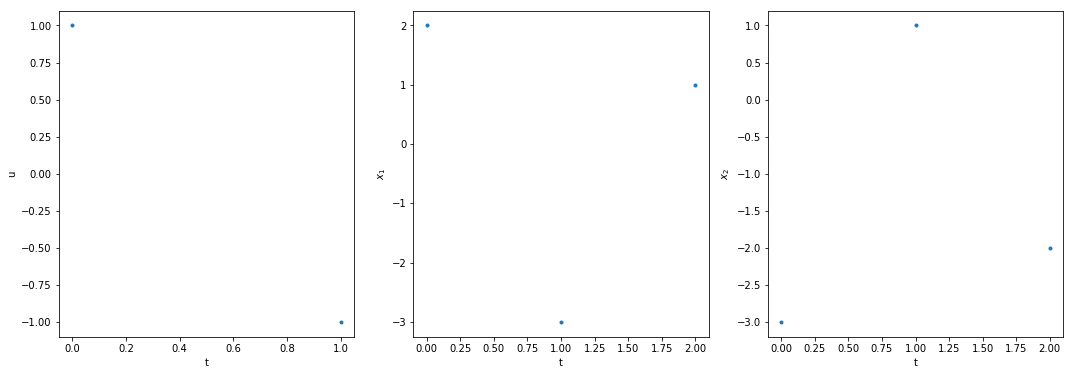

work time :      1.68
Approximate 5.0 
Presize =  5 
Error =  0.0
[ 1. -1.]
[ 2. -3.  1.]
[-3.  1. -2.]


In [24]:
a = DiscreteSystem24(3)
kite2 = KiteSwarm(
    10, #swarm_size
    a.N_step, #dim
    10, #iter_max
    15, #Nc
    20, #Np
    0.4, #integr_steps
    0.2, #step_size
    1, #closenes
    30, #deleted_kites
    1, #dist_min
    3, #k
    [-1, 1], #area
    False) #min
kite2.kso_work(a)
print(kite2.pool[0].u)
print(kite2.best_x1)
print(kite2.best_x2)

In [25]:
for kkite in kite2.pool:
    print(kkite.u, kkite.f)

[ 1. -1.] 5.0
[ 1. -1.] 5.0
[ 1. -1.] 5.0
[ 1. -1.] 5.0
[ 1. -1.] 5.0
[ 1. -1.] 5.0
[ 1. -1.] 5.0
[ 1. -1.] 5.0
[ 1. -1.] 5.0
[ 1. -1.] 5.0


In [35]:
class DiscreteSystem25:
    def __init__(
    self, 
    N_step: int,
    ):
        self.N_step = N_step # N is the dimention of the x, dim for u is the N-1
        self.u_min = 0
        self.u_max = 100
        self.best_x1x2 = np.array([0, 0])

    def make_x(self, u):
        x1 = []
        x2 = []
        x1.append(self.best_x1x2[0])
        x2.append(self.best_x1x2[1])
        u = np.array(u)
        for i in range(1, self.N_step):
            tmp_x1 = x2[i - 1]
            tmp_x2 = 2 * x2[i - 1] - x1[i - 1] + 1 / self.N_step**2 * u[i - 1]
            x1.append(tmp_x1)
            x2.append(tmp_x2)
        x1 = np.array(x1)
        x2 = np.array(x2)
        return x1, x2

    def Functional(self, u):
        x1 = []
        x2 = []
        x1, x2 = self.make_x(u)
        x1 = np.array(x1)
        x2 = np.array(x2)
        #print(x1)
        #print(x2)
        #print('-----------------------------------')
        #print(x1[len(x1) - 1] - 1 / (2 * self.N_step) * sum(np.array(u)**2))
        return x1[len(x1) - 1] - 1 / (2 * self.N_step) * sum(np.array(u)**2)
        
        
    def ExactI(self):
        return 1/3 - (3 * self.N_step - 1) / (6 * self.N_step**2) - 1 / (2 * self.N_step**3) * sum([t**2 for t in range(self.N_step)])

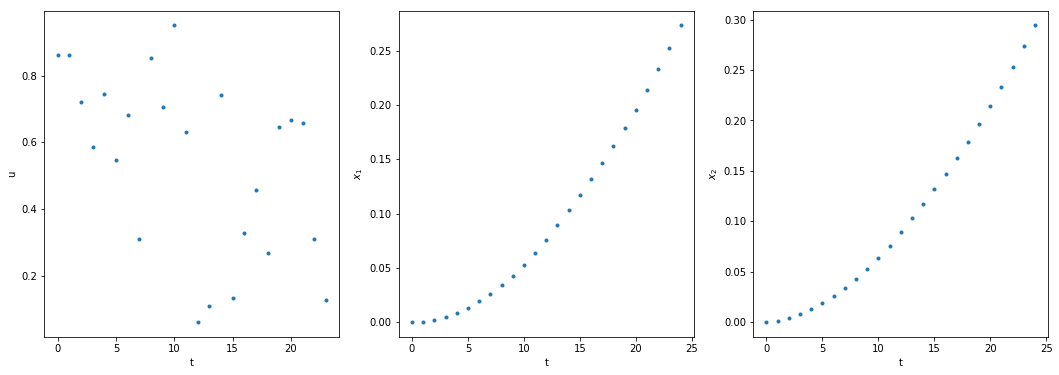

work time :    862.63
Approximate 0.10005705011159752 
Presize =  0.1568 
Error =  0.05674294988840248


In [73]:
b = DiscreteSystem25(25)
kite1 = KiteSwarm(
    150, #swarm_size
    b.N_step, #dim
    20, #iter_max
    15, #Nc
    30, #Np
    0.07, #integr_steps
    0.3, #step_size
    1, #closenes
    20, #deleted_kites
    1, #dist_min
    3, #k
    [0, 1],#area
    True) #max 
kite1.kso_work(b)
# print('\n', kite1.pool[0].u)
# print(kite1.best_x1)
# print(kite1.best_x2)

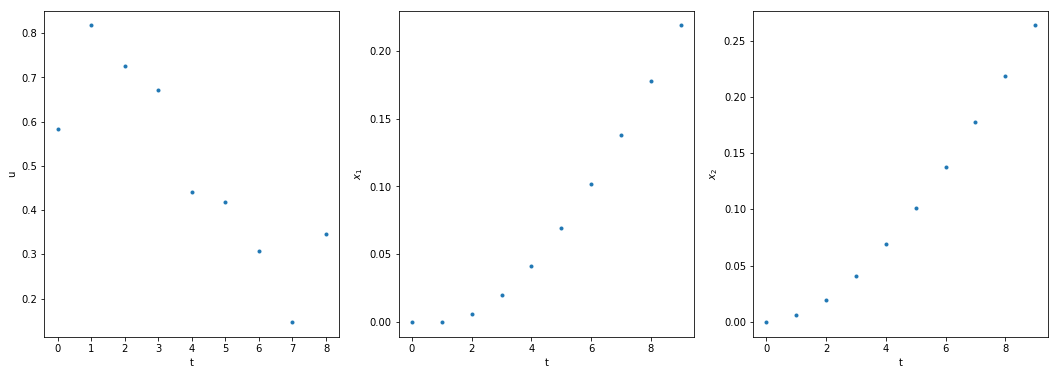

work time :    184.13
Approximate 0.08923519697131954 
Presize =  0.14249999999999996 
Error =  0.05326480302868042
Presize:  0.1425
error:  0.04056873378099246


In [69]:
b1 = DiscreteSystem25(10)
kite11 = KiteSwarm(
    150, #swarm_size
    b1.N_step, #dim
    20, #iter_max
    15, #Nc
    30, #Np
    0.07, #integr_steps
    0.3, #step_size
    1, #closenes
    20, #deleted_kites
    1, #dist_min
    3, #k
    [0, 1],#area
    True) #max 
kite11.kso_work(b1)
print('Presize: ', 0.1425)
print('error: ', 0.1425 - kite1.pool[0].f)

In [70]:
print('error: ', 0.1425 - kite11.pool[0].f)

error:  0.053264803028680446


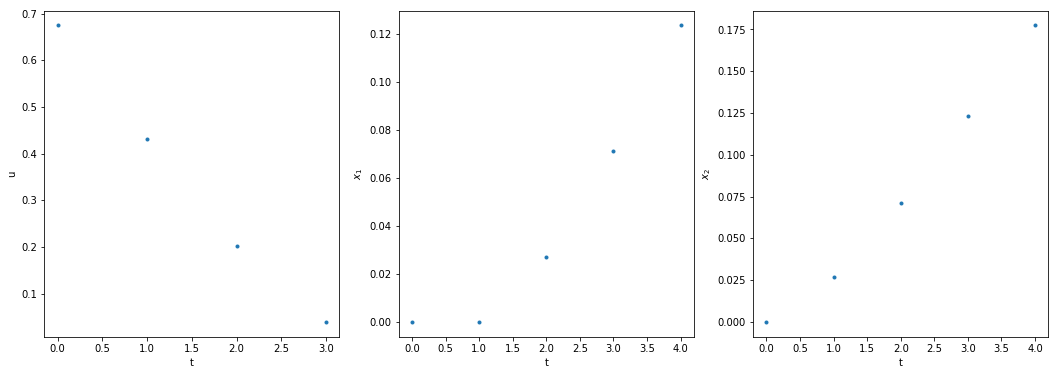

work time :    169.23
Approximate 0.05518767581012311 
Presize =  0.12 
Error =  0.06481232418987688
Presize:  0.12
error:  0.06481232418987688


In [72]:
b2 = DiscreteSystem25(5)
kite12 = KiteSwarm(
    250, #swarm_size
    b2.N_step, #dim
    20, #iter_max
    15, #Nc
    30, #Np
    0.07, #integr_steps
    0.3, #step_size
    1, #closenes
    20, #deleted_kites
    1, #dist_min
    3, #k
    [0, 1],#area
    True) #max 
kite12.kso_work(b2)
print('Presize: ', 0.12)
print('error: ', 0.12 - kite12.pool[0].f)

In [55]:
# for kkite in kite1.pool:
#     print(kkite.u[:5], kkite.f)

In [54]:
# for kkite in kite1.population:
#     print(kkite.u[:5], kkite.f)

In [75]:
class DiscreteSystemLiHames:
    def __init__(
    self, 
    N_step: int,
    ):
        self.N_step = N_step # N is the dimention of the x, dim for u is the N-1
        self.best_x1x2 = np.array([0, 0])

    def make_x(self, u):
        x1 = []
        u = np.array(u)
        x1.append(15)
        if u[0] >= 0:
            x1.append(np.power(x1[0], u[0]))
        else:
            tmp = np.power(x1[0], abs(u[0]))
            x1.append(1 / tmp)
        x1.append((1 + u[1]) * x1[1])
        x1.append(x1[2] + u[2])
        x1 = np.array(x1)
        return x1

    def Functional(self, u):
        x1 = []
        x1 = self.make_x(u)
        x1 = np.array(x1)

        return (x1[0]**2 + x1[1]**2 + (2 * x1[2]**2 + x1[3]**2) * np.exp(x1[1]**2)) * \
                            (50 + u[0]**2 + (u[1]**2 + u[2]**2) * np.exp(u[0]**2))**0.5

        
    def ExactI(self):
        return 1596.4796778

/Users/synthtron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/Users/synthtron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:387: RuntimeWarning: divide by zero encountered in double_scalars


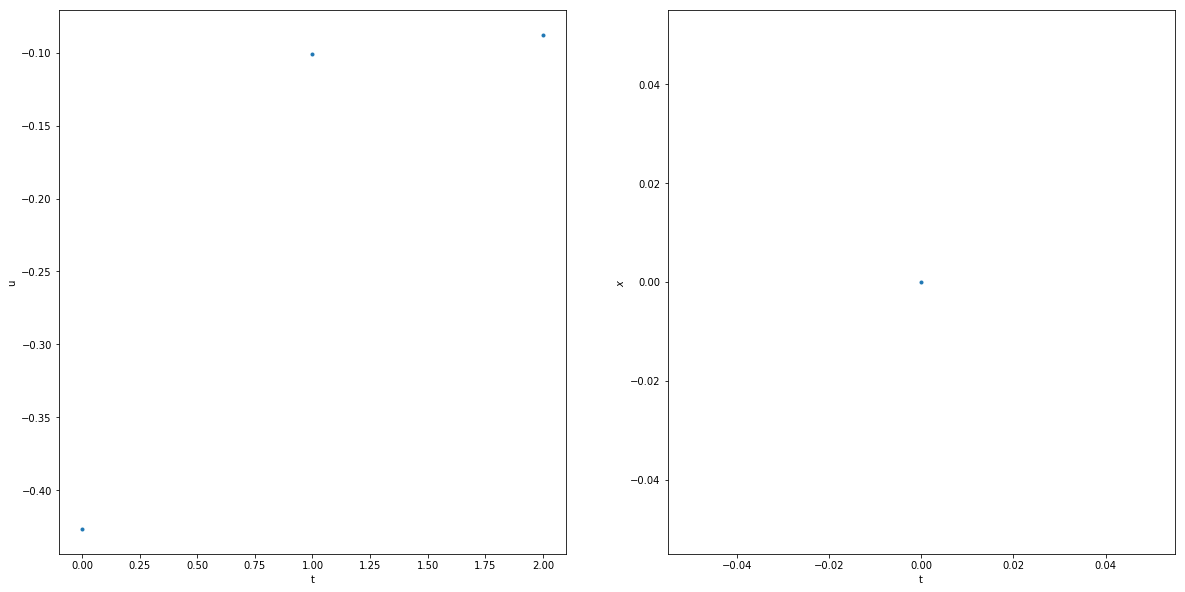

work time :    102.35
Approximate 1596.4805410769075 
Presize =  1596.4796778 
Error =  -0.0008632769074665703


In [76]:
c = DiscreteSystemLiHames(4)
kite3 = KiteSwarm(
    50, #swarm_size
    c.N_step, #dim
    70, #iter_max
    15, #Nc
    30, #Np
    0.07, #integr_steps
    0.3, #step_size
    1, #closenes
    20, #deleted_kites
    1, #dist_min
    3, #k
    [-1, 1],#area
    False) #max 
kite3.kso_work(c)
# print('\n', kite1.pool[0].u)
# print(kite1.best_x1)
# print(kite1.best_x2)

In [ ]:
work time :     16.62
Approximate -4755.84 
Presize =  0.1568 
Error =  4755.9968

In [ ]:
work time :     20.22
Approximate -4386.054463491754 
Presize =  0.1568 
Error =  4386.211263491754

In [ ]:
#проблема
# в population не 15, а 300 особей под конец вычисления программы
# все так же непонятное значение u и выбор наибольшего

In [ ]:
def func_barr1(kite, step4, control):
    # определим списки
    kite.vector_x.clear()
    vector_u = []
    kite_path_barr = [] # стая на каждом шаге
    kite_population_next_step = []
    best_in_each_track = []

    # перелет каждой особи
    for k_i in range(0, kite.swarm_size):
        # очистим все списки
        vector_u = list(vector_u)
        vector_u.clear()

#         kite.vector_x - список всех векторов состояний на горизонте 

        # временно определим vector_r, x_k_i 
        kite.vector_x_ki = np.array([np.concatenate([kite.population[k_i].u, kite.population[k_i].v]) for i in range(kite.Np)])

        # deepcopy R, X_ki для мат операций
        tmp_r = deepcopy(kite.vector_r)
        tmp_x_ki = deepcopy(kite.vector_x_ki)


        # reshape R, X_ki для мат операций
        tmp_r = np.array(tmp_r).reshape((2 * kite.u_dim * kite.Np, 1))
        tmp_x_ki = np.array(tmp_x_ki).reshape((2 * kite.u_dim * kite.Np, 1))


        # --------------ОПРЕДЕЛЕНИЕ ВЕКТОРА U + reshape--------------
        u = np.linalg.inv(kite.Phi.transpose().dot(kite.Phi) + kite.Q).dot(kite.Phi.transpose()).dot(tmp_r - kite.F.dot(tmp_x_ki))
        vector_u.append(u) #зачем аппенд если можно сразу преобразовать в вектор? 

        vector_u = np.block(vector_u) #чтобы из списка преобразовать в матрицу?
        vector_u = vector_u.reshape((kite.u_dim, kite.Nc)).transpose()
#         print('u', '\n', vector_u)


        # --------------ОПРЕДЕЛЕНИЕ ВЕКТОРА U  для шага 2.1 или 4--------------
        if(step4 == 0):
            temp = np.zeros((kite.Nc, kite.Nc))
            temp[0, 0] = 1.0
            u = temp.dot(vector_u)
#             print('u', '\n', u)
        
        
        kite_path_barr.clear()

        # --------------ВЫЧИСЛЕНИЕ НОВЫХ КООРДИНАТ (ТЕКУЩЕГО КОРШУНА) ВЕКТОРА X_ki--------------
        # когда Nc (Nc<Np) заканчивается, u определяем как [0., 0.]
        for i in range(kite.Np):

            if(i < len(vector_u)):
                u_i = vector_u[i]
            else:
                u_i = np.zeros(kite.u_dim)

            tmp_x = kite.A.dot(kite.vector_x_ki[i]) + kite.B.dot(u_i) 
            coordinate = tmp_x[:kite.u_dim]
            velocity = tmp_x[kite.u_dim: kite.u_dim*2+1]


            # проверка на выход за границы, если вышли - берем крайнее значение
            for j in range(len(coordinate)):
                if coordinate[j] < kite.area[j][0]:
#                     print('вылетели 1')
                    coordinate[j] = kite.area[j][0]
                elif coordinate[j] > kite.area[j][1]:
#                     print('вылетели 2')
                    coordinate[j] = kite.area[j][1]

                if velocity[j] < kite.area[j][0]:
#                     print('вылетели 3')
                    velocity[j] = kite.area[j][0]
                elif velocity[j] > kite.area[j][1]:
#                     print('вылетели 4')
                    velocity[j] = kite.area[j][1]

            result = control.Functional(coordinate)
            member = Kite(coordinate, velocity, result)
            kite_path_barr.append(member) #записываем сюда весь трэк коршуна, чтобы потом выбрать конкретное положение
            
        kite.vector_x.append(kite_path_barr)
        
        kite_pb = deepcopy(kite_path_barr)
        kite_pb.sort(reverse=False, key=lambda kite_: kite_.f)
#         kite_population_next_step.append(deepcopy(kite_path_barr[kite.Np-1]))
        kite_population_next_step.append(deepcopy(kite_pb[0]))
    
    kite.population.clear()
    kite.population = deepcopy(kite_population_next_step)
    print(len(self.population))
    kite_population_next_step.clear()
    
    
# step_size: float, #size of integration steps --- (h = 2 in article)
def move_kite_1(kite, control):
    u_step3 = []
    T = 10
    i = 0
    for kite_01 in kite.population[0:]:
        firts = 6 * (kite.leader_kite.u - kite_01.u) / ((kite.swarm_size - i)**2 * kite.step_size**2)
        second = 4 * kite_01.v / ((kite.swarm_size - i) * kite.step_size)
        ++i
        result = firts - second
        u_step3.append(result)
    s = np.array([np.concatenate([kite.population[i].u, kite.population[i].v]) for i in range(kite.swarm_size)])
    s = np.transpose(s)
    u_step3 = np.transpose(u_step3)
    x = kite.A.dot(s) + kite.B.dot(u_step3)
    x = np.transpose(x)
    list1 = []
    for ii in range(kite.swarm_size):
        coordinate = x[ii][:kite.u_dim]
        velocity = x[ii][kite.u_dim: kite.u_dim*2+1]
        result = control.Functional(coordinate)
        member = Kite(coordinate, velocity, result)
        list1.append(member)
        
    list1.sort(reverse=False, key=lambda kite_: kite_.f)
    kite.population[1] = list1[1]
    kite.best_kite.append(list1[1])
    
    
def delete_kites(kite, control):
    # deleted_kites: float, #parameter of deleted kites --- (sigma in article)
    number_of_deleted = round(kite.deleted_kites * kite.swarm_size, 0)
    for i in range(number_of_deleted):
        if(len(kite.population) != 0):
            kite.population.pop()
    for i in range(number_of_deleted):
        coordinate = np.array([np.random.rand() * \
                            (kite.area[j][1] - kite.area[j][0]) + kite.area[j][0] \
                              for j in range(kite.u_dim)])

        velocity = np.array([(np.random.rand() * \
                    (kite.area[j][1] - kite.area[j][0]) + kite.area[j][0]) / kite.integr_steps \
                              for j in range(kite.u_dim)])

        result = control.Functional(coordinate)
        member = Kite(coordinate, velocity, result)
        kite.population.append(member)
        

In [ ]:
def kso_work(kite, control):
    start = time.monotonic()
    time.sleep(0.1)
    kite.init_area(control)
    kite.population.clear()
    kite.form_first_pop(control)
    
    kite.func_calculate(control)
    
    kite.population.sort(reverse=False, key=lambda kite_: kite_.f)
    kite.pool.append(kite.population[0])

    # --------- шаг 2 --------- (добавить цикл iter_max)

    kite.vector_r = np.array([np.concatenate([kite.population[0].u, kite.population[0].v]) for i in range(kite.Np)])
    for j in range(kite.iter_max): 
        for i in range(kite.Nc):
            func_barr1(kite, 1, control)
        kite.population.sort(reverse=False, key=lambda kite_: kite_.f)
        kite.pool.append(kite.population[0])
        kite.vector_r = np.array([np.concatenate([kite.population[0].u, kite.population[0].v]) for i in range(kite.Np)])

    # --------- шаг 3 ---------

        kite.leader_kite = kite.population[0]
        kite.leader_kite.v = np.zeros(kite.u_dim)
        kite.first_kite = kite.population[1]
        kite.second_kite = kite.population[2]
        kite.third_kite = kite.population[3]
        kite.best_kite = []
        move_kite_1(kite, control)

    # --------- шаг 4 ---------

        func_barr1(kite, 0, control)

    # --------- шаг 5 ---------
        delete_kites(kite, control)
        kite.population.sort(reverse=False, key=lambda kite_: kite_.f)

    kite.pool.sort(reverse=False, key=lambda kite_: kite_.f)
    end = time.monotonic()
    make_best_x(kite, kite.pool[0].u, control.best_x1x2)
    draw_plots(kite)


    print('work time : {:>9.2f}'.format(end-start))
    print('Approximate', kite.pool[0].f,'\nPresize = ', kite.exact,'\nError = ', (kite.exact - kite.pool[0].f))

In [ ]:
    def make_best_x(self, u, best_x1x2):
        self.best_x1.clear()
        self.best_x2.clear()
        self.best_x1.append(best_x1x2[0])
        self.best_x2.append(best_x1x2[1])
        for i in range(1, self.dim):
            tmp_x1 = self.best_x2[i - 1]
            tmp_x2 = 2 * self.best_x2[i - 1] - self.best_x1[i - 1] + 1 / (self.dim**2) * u[i - 1]
            self.best_x1.append(tmp_x1)
            self.best_x2.append(tmp_x2)
        self.best_x1 = np.array(self.best_x1)
        self.best_x2 = np.array(self.best_x2)
    
    def draw_plots(self):
        plt.figure(figsize=(18, 6))

        plt.subplot(1,3,1)
        #plt.plot(self.best_list[0].u, '.')
        plt.plot(self.pool[0].u, '.')
        plt.ylabel('u')
        plt.xlabel('t')

        plt.subplot(1,3,2)
        plt.plot(self.best_x1, '.')
        plt.ylabel('$x_{1}$')
        plt.xlabel('t')

        plt.subplot(1,3,3)
        plt.plot(self.best_x2, '.')
        plt.ylabel('$x_{2}$')
        plt.xlabel('t')

        plt.show()